# Explainability for PyTorch Models

We use 

```
@misc{jacobgilpytorchcam,
  title={PyTorch library for CAM methods},
  author={Jacob Gildenblat and contributors},
  year={2021},
  publisher={GitHub},
  howpublished={\url{https://github.com/jacobgil/pytorch-grad-cam}},
}
```

In [1]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [2]:
from scr.pytorch_model_defs import WaterPlasticModel

In [3]:
model = torch.load('pytorch_models/100_epochs_default.pth', weights_only=False)

In [4]:
# Load the data
from scr.pytorch_data_loaders import load_data_from_directory, ImageDataset

In [5]:
# # Paths to your data directories
# train_dir = "data/classification_dataset/train"
# validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# # Load the data
# train_images, train_labels = load_data_from_directory(train_dir)
# val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# train_dataset = ImageDataset(train_images, train_labels, transform=None)
# val_dataset = ImageDataset(val_images, val_labels, transform=None)
test_dataset = ImageDataset(test_images, test_labels, transform=None)



In [6]:
test_dataset

In [57]:
BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,       # Shuffle only for training
#     num_workers=2,      # Adjust based on your system
#     pin_memory=True     # Speeds up GPU transfer if using CUDA
# )

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,      # Typically no shuffle for validation
#     num_workers=2,
#     pin_memory=True
# )

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Typically no shuffle for test
    num_workers=2,
    pin_memory=True
)

# GradCAM

In [8]:
model

WaterPlasticModel(
  (conv1): Conv2d(12, 16, kernel_size=(12, 12), stride=(1, 1), padding=(6, 6))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(12, 12), stride=(1, 1), padding=(6, 6))
  (conv3): Conv2d(32, 64, kernel_size=(12, 12), stride=(1, 1), padding=(6, 6))
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
)

In [205]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt


In [365]:
for images, labels in test_loader:
    input_tensor = images
    break

In [341]:
input_tensor.shape

torch.Size([32, 12, 32, 32])

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

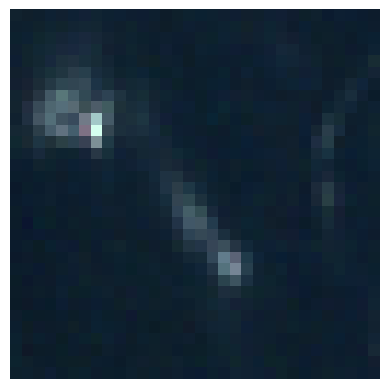

In [366]:
rgb_image = input_tensor[0, :][[3,2,1], :, :]
rgb_image = rgb_image.permute(1,2,0).numpy()
plt.imshow((rgb_image / np.max(rgb_image) * 255).astype(np.uint8))
plt.axis('off')
# plt.imshow((rgb_image / np.max(rgb_image) * 255).astype(np.uint8))

In [340]:
input_tensor[0, :]

tensor([[[3.4500e-02, 3.4500e-02, 3.4500e-02,  ..., 3.5700e-02,
          3.5700e-02, 3.5700e-02],
         [3.4200e-02, 3.4200e-02, 3.4200e-02,  ..., 4.2600e-02,
          4.2600e-02, 4.2600e-02],
         [3.4200e-02, 3.4200e-02, 3.4200e-02,  ..., 4.2600e-02,
          4.2600e-02, 4.2600e-02],
         ...,
         [5.1400e-02, 5.1400e-02, 5.1400e-02,  ..., 3.5500e-02,
          3.5500e-02, 3.5500e-02],
         [5.1400e-02, 5.1400e-02, 5.1400e-02,  ..., 3.5500e-02,
          3.5500e-02, 3.5500e-02],
         [4.1000e-02, 4.1000e-02, 4.1000e-02,  ..., 3.4000e-02,
          3.4000e-02, 3.4000e-02]],

        [[4.9400e-02, 5.0200e-02, 5.1700e-02,  ..., 5.1100e-02,
          4.9400e-02, 4.8300e-02],
         [4.9400e-02, 4.9400e-02, 4.9000e-02,  ..., 4.7100e-02,
          5.1700e-02, 4.7500e-02],
         [4.8000e-02, 4.5300e-02, 4.5200e-02,  ..., 4.9700e-02,
          5.3500e-02, 5.0000e-02],
         ...,
         [6.9400e-02, 8.0100e-02, 8.8600e-02,  ..., 4.6100e-02,
          4.970

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

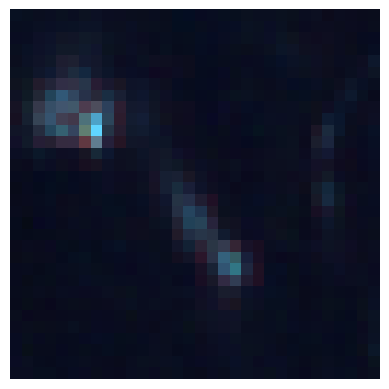

In [367]:
nir_image = input_tensor[0, :][[8,3,2], :, :]
nir_image = nir_image.permute(1,2,0).numpy()
plt.imshow((nir_image / np.max(nir_image) * 255).astype(np.uint8))
plt.axis('off')

In [369]:
target_layers = [model.conv3]
# target_layers = [model.conv1]
# target_layers = [model.conv2]

cam = GradCAM(model=model, target_layers=target_layers)

In [370]:
print(f"Current Label: {labels[0]}")

Current Label: 1


In [428]:
targets = [ClassifierOutputTarget(1)]

In [429]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)


In [430]:
input_tensor.shape

torch.Size([32, 12, 32, 32])

In [431]:
rgb_image

array([[[0.0078, 0.0155, 0.021 ],
        [0.0074, 0.0143, 0.0197],
        [0.0067, 0.0143, 0.0206],
        ...,
        [0.0057, 0.0138, 0.0227],
        [0.0058, 0.0128, 0.0215],
        [0.0061, 0.0127, 0.0202]],

       [[0.0064, 0.0142, 0.0204],
        [0.0064, 0.0145, 0.021 ],
        [0.0076, 0.0155, 0.0201],
        ...,
        [0.0058, 0.0142, 0.0202],
        [0.005 , 0.0138, 0.0209],
        [0.0064, 0.0135, 0.0206]],

       [[0.0058, 0.0151, 0.0208],
        [0.0062, 0.0153, 0.0226],
        [0.0076, 0.0173, 0.021 ],
        ...,
        [0.0057, 0.0127, 0.0192],
        [0.0053, 0.0142, 0.0213],
        [0.0054, 0.0148, 0.0223]],

       ...,

       [[0.0058, 0.0152, 0.0203],
        [0.0072, 0.0111, 0.0178],
        [0.0058, 0.013 , 0.0184],
        ...,
        [0.0065, 0.0135, 0.0203],
        [0.007 , 0.0122, 0.0212],
        [0.0105, 0.0181, 0.0242]],

       [[0.0058, 0.0158, 0.0208],
        [0.0072, 0.0145, 0.0198],
        [0.0057, 0.0132, 0.0194],
        .

In [432]:
grayscale_cam

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [433]:
# In this example grayscale_cam has only one image in the batch:
visualization = show_cam_on_image(rgb_image, grayscale_cam[0, :], use_rgb=True)

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

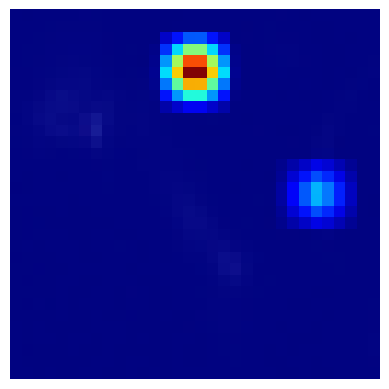

In [427]:
plt.imshow(visualization)
plt.axis('off')